In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr

import findlay2025a as f25a
import wisc_ecephys_tools as wet
from ecephys import npsig, units

In [4]:
nbsh = wet.get_sglx_project("seahorse")

ccg_window_size = 2000  # ms
ccg_bin_size = 25  # ms
ccg_states = ["NREM", "Wake", "IS", "REM"]

n_surrogates = 100
jitter = 1  # seconds

In [ ]:
ccg_dfs = []
for subject, experiment in f25a.core.yield_subject_name_experiment_pairs():
    print(f"Doing {subject} {experiment}...")
    spws = f25a.sharp_waves.read_spws(subject, experiment)
    ds = f25a.dentate_spikes.read_dspks(subject, experiment)
    ripples = f25a.ripples.read_ripples(subject, experiment)
    cx_sps, cx_trghs = f25a.spindles.read_spindles(
        subject, experiment, region="cortical"
    )

    trains = {
        "SPW": spws["pk_time"].values,
        "Ripple": ripples["pk_time"].values,
        "DS": ds["peak_time"].values,
        "Cortical Spindle": cx_sps["Peak"].values,
        "Cortical Spindle Trough": cx_trghs,
    }

    hgs = f25a.hypnograms.load_statistical_condition_hypnograms(
        experiment, subject, include_full_conservative=True
    )
    hg = hgs.pop("full_conservative").drop_states(
        f25a.core.ARTIFACT_STATES + ["NoData"]
    )

    print("Computing CCGs...")
    ccgs = units.compute_intrapopulation_correlograms_by_hypnogram_state(
        trains, hg, ccg_window_size, ccg_bin_size, states=ccg_states
    )

    print("Computing shift predictor...")
    jittered_trains = {
        k: npsig.events.jitter_train(v, jitter, n_surrogates) for k, v in trains.items()
    }
    jittered_ccgs = xr.concat(
        [
            units.compute_intrapopulation_correlograms_by_hypnogram_state(
                {k: jittered_trains[k][i] for k in jittered_trains},
                hg,
                ccg_window_size,
                ccg_bin_size,
                states=ccg_states,
            )
            for i in range(n_surrogates)
        ],
        dim="Surrogate",
    )
    shift_predictor = jittered_ccgs.mean(dim="Surrogate")
    adjusted_ccgs = ccgs - shift_predictor

    dat = xr.Dataset(
        {
            "Collisions": ccgs,
            "Shift Predictor": shift_predictor,
            "Adjusted Collisions": adjusted_ccgs,
            "Probability": ccgs / ccgs.num_spikes_A,
            "Adjusted Probability": adjusted_ccgs / ccgs.num_spikes_A,
        }
    )

    ccg_df = dat.to_dataframe().reset_index()
    ccg_df["Subject"] = subject
    ccg_df["Experiment"] = experiment
    ccg_dfs.append(ccg_df)

df = pd.concat(ccg_dfs, ignore_index=True)
df.rename(
    columns={"clusterA": "A", "clusterB": "B", "state": "State", "time": "Time"},
    inplace=True,
)
df.to_parquet(nbsh.get_project_file("coupling_by_state.pqt"))

Doing CNPIX2-Segundo novel_objects_deprivation...
Computing CCGs...
Computing shift predictor...
Doing CNPIX3-Valentino novel_objects_deprivation...
Computing CCGs...
Computing shift predictor...
Doing CNPIX4-Doppio novel_objects_deprivation...
Computing CCGs...
Computing shift predictor...
Doing CNPIX5-Alessandro novel_objects_deprivation...
Computing CCGs...
Computing shift predictor...
Doing CNPIX6-Eugene novel_objects_deprivation...
Computing CCGs...
Computing shift predictor...
Doing CNPIX8-Allan novel_objects_deprivation...
Computing CCGs...
Computing shift predictor...
Doing CNPIX9-Luigi novel_objects_deprivation...
Computing CCGs...
Computing shift predictor...
Doing CNPIX10-Charles novel_objects_deprivation...
Computing CCGs...
Computing shift predictor...
Doing CNPIX11-Adrian novel_objects_deprivation...
Computing CCGs...
Computing shift predictor...
Doing CNPIX12-Santiago novel_objects_deprivation...
Computing CCGs...
Computing shift predictor...
Doing CNPIX14-Francis novel_

In [ ]:
# Smooth the data along the time dimension
from scipy import ndimage

# Define smoothing parameters
sigma = 0.8  # Standard deviation for Gaussian kernel (in bins)

# Smooth numerical columns along time dimension
smooth_cols = [
    "Collisions",
    "Shift Predictor",
    "Adjusted Collisions",
    "Probability",
    "Adjusted Probability",
]

# Group by all non-time dimensions and smooth each group
grouped = df.groupby(["A", "B", "Subject", "Experiment", "State"])

smoothed_dfs = []
for name, group in grouped:
    group_sorted = group.sort_values("Time")
    smoothed_group = group_sorted.copy()

    for col in smooth_cols:
        smoothed_group[col] = ndimage.gaussian_filter1d(
            group_sorted[col].values, sigma=sigma
        )

    smoothed_dfs.append(smoothed_group)

sdf = pd.concat(smoothed_dfs, ignore_index=True)


In [19]:
colorblind_palette = sns.color_palette("colorblind")
state_colors = {
    "Wake": colorblind_palette[2],
    "NREM": colorblind_palette[0],
    "IS": colorblind_palette[3],
    "REM": colorblind_palette[1],
}

In [105]:
def plot_coupling_by_state(
    df: pd.DataFrame,
    trigger: str,
    response: str,
    vars: list[str] = [
        "Collisions",
        "Adjusted Collisions",
        "Probability",
        "Adjusted Probability",
    ],
    states: list[str] = list(state_colors.keys()),
    height: float = 4,
    plot_for_pub: bool = False,
):
    width = height
    n_vars = len(vars)
    fig, axes = plt.subplots(1, n_vars, figsize=(n_vars * width, height))
    if n_vars == 1:
        axes = [axes]
    for i, var in enumerate(vars):
        _df = df[(df["A"] == trigger) & (df["B"] == response)]

        sns.lineplot(
            data=_df,
            x="Time",
            y=var,
            hue="State",
            hue_order=states,
            palette=state_colors,
            ax=axes[i],
            legend=not plot_for_pub,
        )
        axes[i].axvline(x=0, color="black", linestyle="--")

    if plot_for_pub:
        for ax in axes:
            ax.set_xlabel("")
            ax.set_ylabel("")
    return fig, axes

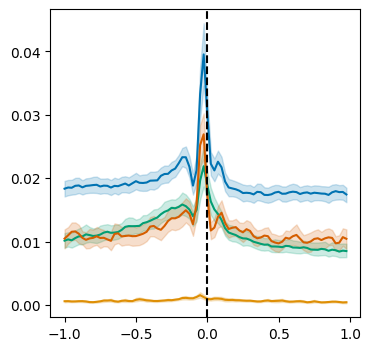

In [118]:
trigger = "DS"
response = "Ripple"

fig, axes = plot_coupling_by_state(
    sdf, trigger, response, vars=["Probability"], plot_for_pub=True
)
fig.savefig(
    nbsh.get_project_file(
        f"figures/coupling_by_state_{trigger}_{response}_probability_smoothed.png"
    ),
    dpi=300,
)

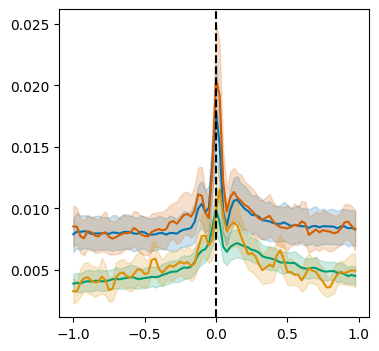

In [120]:
trigger = "Ripple"
response = "DS"

fig, axes = plot_coupling_by_state(
    sdf, trigger, response, vars=["Probability"], plot_for_pub=True
)
fig.savefig(
    nbsh.get_project_file(
        f"figures/coupling_by_state_{trigger}_{response}_probability_smoothed.png"
    ),
    dpi=300,
)

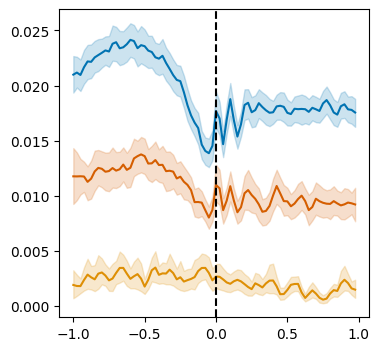

In [ ]:
trigger = "Cortical Spindle"
response = "Ripple"

fig, axes = plot_coupling_by_state(
    sdf,
    trigger,
    response,
    vars=["Probability"],
    states=["NREM", "IS", "REM"],
    plot_for_pub=True,
)
fig.savefig(
    nbsh.get_project_file(
        f"figures/coupling_by_state_{trigger}_{response}_probability_smoothed.png"
    ),
    dpi=300,
)

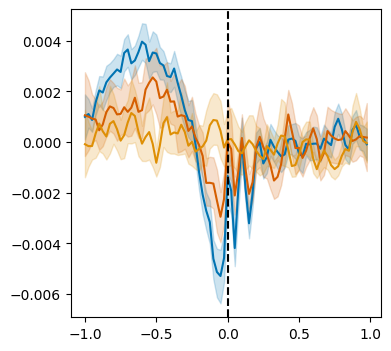

In [ ]:
trigger = "Cortical Spindle"
response = "Ripple"

fig, axes = plot_coupling_by_state(
    sdf,
    trigger,
    response,
    vars=["Adjusted Probability"],
    states=["NREM", "IS", "REM"],
    plot_for_pub=True,
)
fig.savefig(
    nbsh.get_project_file(
        f"figures/coupling_by_state_{trigger}_{response}_adjusted_probability_smoothed.png"
    ),
    dpi=300,
)

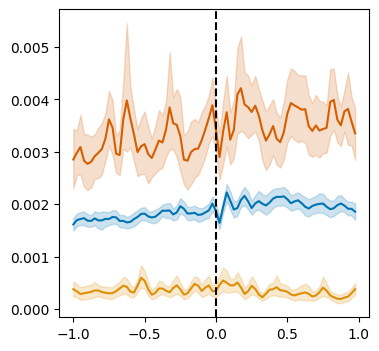

In [ ]:
trigger = "DS"
response = "Cortical Spindle"

fig, axes = plot_coupling_by_state(
    sdf,
    trigger,
    response,
    vars=["Probability"],
    states=["NREM", "IS", "REM"],
    plot_for_pub=True,
)
fig.savefig(
    nbsh.get_project_file(
        f"figures/coupling_by_state_{trigger}_{response}_probability_smoothed.png"
    ),
    dpi=300,
)

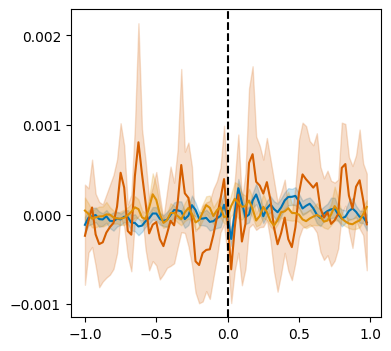

In [ ]:
trigger = "DS"
response = "Cortical Spindle"

fig, axes = plot_coupling_by_state(
    sdf,
    trigger,
    response,
    vars=["Adjusted Probability"],
    states=["NREM", "IS", "REM"],
    plot_for_pub=True,
)
for ax in axes:
    # Limit tick labels to 3 decimal places
    ax.set_yticks([-0.001, 0.00, 0.001, 0.002])
fig.savefig(
    nbsh.get_project_file(
        f"figures/coupling_by_state_{trigger}_{response}_adjusted_probability_smoothed.png"
    ),
    dpi=300,
)